In [1]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import pathlib
import os

## Function to process images for Inference
Is the same code as in Eval/data_util_eval.py

In [2]:
CROP_PROPORTION = 0.875

def center_crop(image, height, width, crop_proportion):
    #Crops to center of image and rescales to desired size
    #removed original functions, the result is the same if we use this
    #instead of original func. (almost in our case) see transformations.py in the folder Notebooks_for_debug
    image = tf.image.central_crop(image, crop_proportion)
    image = tf.image.resize([image], [height, width], method=tf.image.ResizeMethod.BICUBIC)[0]

    return image


def preprocess_for_eval(image, height, width, crop=True):
    """Preprocesses the given image for evaluation.

    Args:
    image: `Tensor` representing an image of arbitrary size.
    height: Height of output image.
    width: Width of output image.
    crop: Whether or not to (center) crop the test images.

    Returns:
    A preprocessed image `Tensor`.
    """
    if crop:
        image = center_crop(image, height, width, crop_proportion=CROP_PROPORTION)
    image = tf.reshape(image, [height, width, 3])
    image = tf.clip_by_value(image, 0., 1.)
    return image


def preprocess_image(image, height, width):
    """Preprocesses the given image.
    Args:
    image: `Tensor` representing an image of arbitrary size.
    height: Height of output image.
    width: Width of output image.
    Returns:
    A preprocessed image `Tensor` of range [0, 1].
    """
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)

    return preprocess_for_eval(image, height, width)

### Create the mini ds

In [3]:
data_dir = './Pets/'
data_dir = pathlib.Path(data_dir)
batch_size = 10

In [4]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['Gato' 'Perro']


In [5]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    one_hot = parts[-2] == class_names
    # Integer encode the label
    return tf.argmax(one_hot)

def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # resize the image to the desired size
    return img

def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    img = preprocess_image(img, height=100, width=100)
    return img, label

def configure_for_performance(ds):
    ds = ds.cache()
    #ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds

#function to convert float32 image to uint8
def convert(img, target_type_min=0, target_type_max=255, target_type='uint8'):
    imin = img.min()
    imax = img.max()

    a = (target_type_max - target_type_min) / (imax - imin)
    b = target_type_max - a * imax
    new_img = (a * img + b).astype(target_type)
    return new_img

In [6]:
ds = list_ds.take(10)
ds = ds.map(process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds = configure_for_performance(ds)

In [7]:
image_batch, label_batch = next(iter(ds))
converted=[]
for i in range(10):
    img1 = convert(image_batch[i].numpy())
    converted.append(img1)


### Show images for Eval (reconverted to uint8)

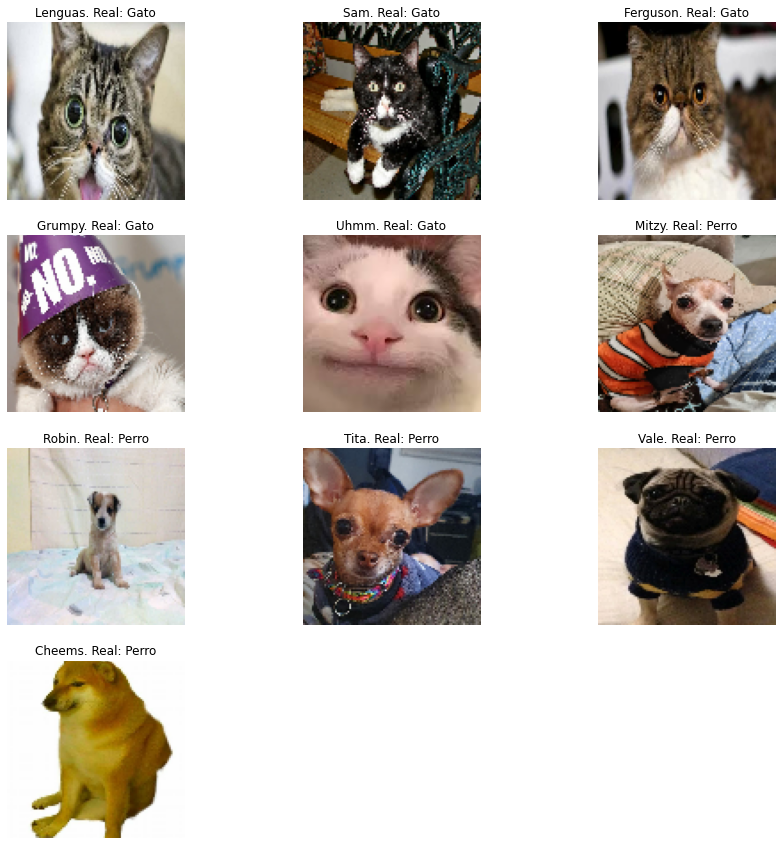

In [8]:
names = ['Lenguas', 'Sam', 'Ferguson', 'Grumpy', 'Uhmm', 'Mitzy', 'Robin', 'Tita', 'Vale', 'Cheems']
plt.figure(figsize=(15, 15))
for i in range(10):
    ax = plt.subplot(4, 3, i + 1)
    plt.imshow(converted[i])
    label = label_batch[i]
    plt.title(names[i] + '. Real: ' + class_names[label])
    plt.axis("off")
plt.savefig('original.jpg')

## Load model finetuned with 10% of images and infer

In [9]:
saved_model_10pct = tf.saved_model.load('./saved_model_10pct/saved_model/')

In [10]:
for image, label in ds.take(1):
    logits_10pct = saved_model_10pct(image, trainable=False)['logits_sup']
    pred_10pct = tf.argmax(logits_10pct, -1)

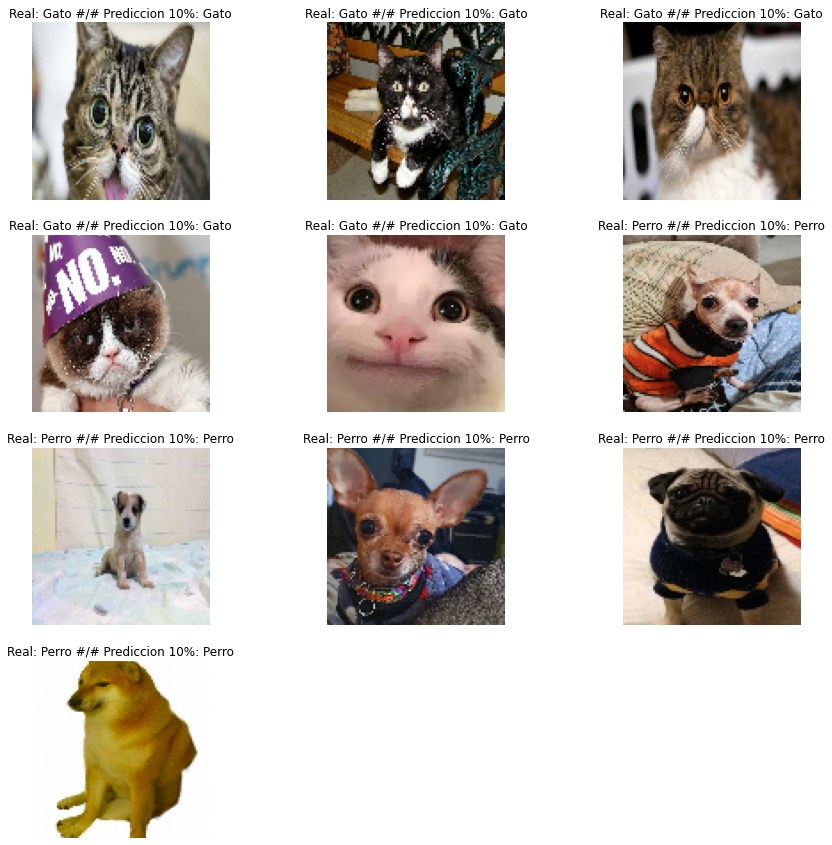

In [11]:
plt.figure(figsize=(15, 15))
for i in range(10):
    ax = plt.subplot(4, 3, i + 1)
    plt.imshow(converted[i])
    label = class_names[label_batch[i]]
    predicted = class_names[pred_10pct[i]]
    plt.title('Real: ' + label + ' #/# Prediccion 10%: ' + predicted)
    plt.axis("off")
plt.savefig('10pct.jpg')

## Load model finetuned with 1% of images and infer

In [12]:
saved_model_1pct = tf.saved_model.load('./saved_model_1pct/saved_model/')
for image, label in ds.take(1):
    logits_1pct = saved_model_1pct(image, trainable=False)['logits_sup']
    pred_1pct = tf.argmax(logits_1pct, -1)

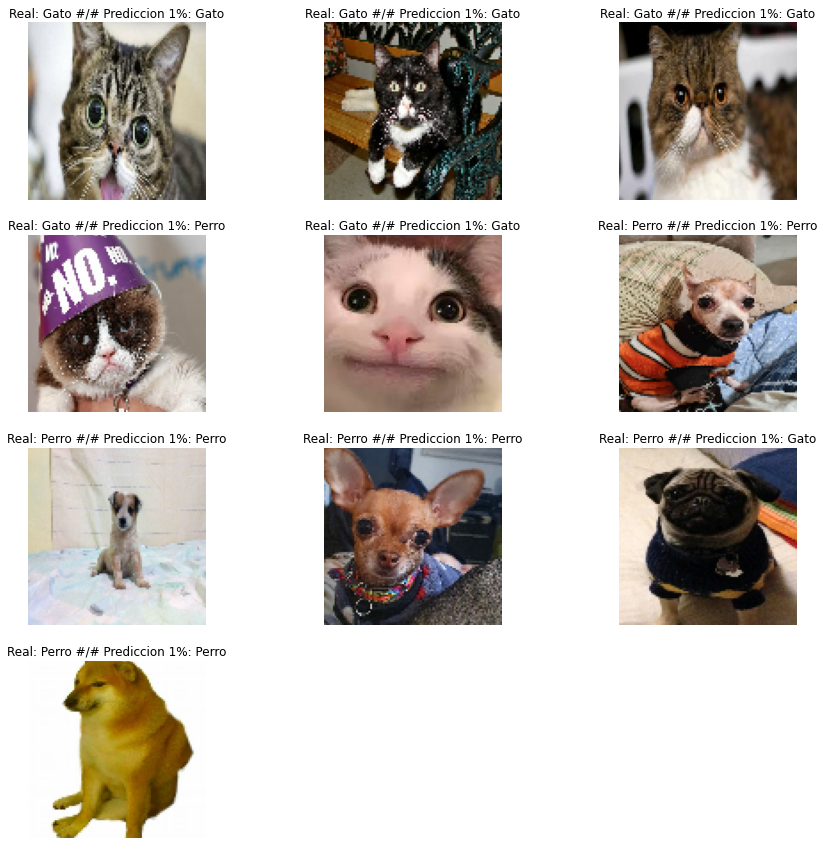

In [13]:
plt.figure(figsize=(15, 15))
for i in range(10):
    ax = plt.subplot(4, 3, i + 1)
    plt.imshow(converted[i])
    label = class_names[label_batch[i]]
    predicted = class_names[pred_1pct[i]]
    plt.title('Real: ' + label + ' #/# Prediccion 1%: ' + predicted)
    plt.axis("off")
plt.savefig('1pct.jpg')

## Load model finetuned with 100% of images and infer

In [14]:
saved_model_100pct = tf.saved_model.load('./saved_model_100pct/saved_model/')
for image, label in ds.take(1):
    logits_100pct = saved_model_100pct(image, trainable=False)['logits_sup']
    pred_100pct = tf.argmax(logits_100pct, -1)

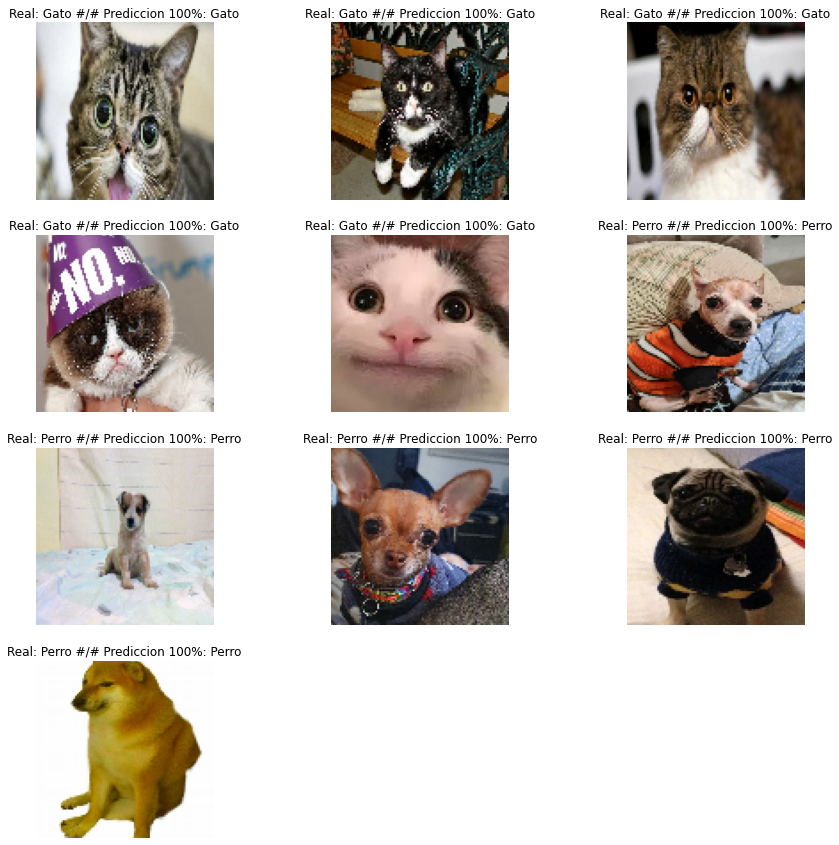

In [15]:
plt.figure(figsize=(15, 15))
for i in range(10):
    ax = plt.subplot(4, 3, i + 1)
    plt.imshow(converted[i])
    label = class_names[label_batch[i]]
    predicted = class_names[pred_100pct[i]]
    plt.title('Real: ' + label + ' #/# Prediccion 100%: ' + predicted)
    plt.axis("off")
plt.savefig('100pct.jpg')